In [8]:
import matplotlib.pyplot as plt
# Arnav Iyer | arnaviyer@my.unt.edu

In [9]:
filename1 = "TestCases/CE/E-n76-k7.vrp"
filename2 = "TestCases/CE/E-n30-k3.vrp"

In [10]:
coordList = getCoordList2(filename1)

In [5]:
#my rss which improves times?

import csv
import math

def getEuclidInfo(coordList):

    amt = len(coordList)

    adjList = [[-1 for i in range(amt)] for i in range(amt)]
    popList = [-1 for i in range(amt)]

    for i in range(amt):                      # coordList is N x 3 array with (x-coord,y-coord,demand)
        popList[i] = coordList[i][2]
        for j in range(amt):
            adjList[i][j] = math.hypot(coordList[i][0]-coordList[j][0], coordList[i][1]-coordList[j][1])

    return amt, adjList, popList

def getCoordList(filename):
    file = open(filename, "r") 
    info = file.readlines()
    file.close()
    amt = len(info)-1
    coordList = [[-1 for i in range(3)] for i in range(amt)]
    for i in range(amt):
        r = info[i].split()
        for j in range(3):
            coordList[i][j] = float(r[j])
    
    truckCapacity = int(info[amt].split()[0])
    costMax = int(info[amt].split()[1])

    return coordList, truckCapacity, costMax


def inputData():
    filename = "inputfile.csv"
    header = []
    rows = []
    amt = 0
    
    with open(filename, 'r') as csvfile:
        fin = csv.reader(csvfile)
        header = next(fin)
        stillRSS = True
        for row in fin:
            if int(row[0]) == 1 and stillRSS:
                stillRSS = False
                amt = fin.line_num - 1
            rows.append(row)
 
    adjList = [[-1 for i in range(amt)] for i in range(amt)]
    popList = [-1 for i in range(amt)]
    count = -1
    for row in rows:
        count += 1
        if count % 151 == 0 and count != 0:
            popList[int(row[0])] = int(row[2])
        if int(row[3]) == 152:     
            adjList[int(row[0])][0] = float(row[5])
        else:
            adjList[int(row[0])][int(row[3])] = float(row[5])
    
    return amt, adjList, header, rows, popList

def getPerms(nums):
    if len(nums) == 1:
        return [nums]

    perms = []
    for i in range(len(nums)):
        othernums = nums[:i] + nums[i+1:]
        otherperms = getPerms(othernums)
        for perm in otherperms:
            perms.append( [nums[i]]+ perm)
    return perms

def rankDist(adjList, amt):
    distRank = []
    for i in range(amt):
        distRank.append([[adjList[i]][0],i])
    distRank.sort()
    return distRank

class graph:
    
    # parameterized constructor
    def __init__(self, amt, adjList, popList, truckCapacity = None, costMax=None, unloadingTime=None):
        self.adjList = adjList # adjacency matrix
        self.popList = popList # stores population of each POD
        self.amt = amt # stores the amount of nodes
        self.tourList = [] # stores tour sets
        self.infoList = [] # stores population and cost of each tour in tourList
        self.podVehicle = [] # stores maximum vehicle size per pod
        self.truckCapacity = truckCapacity
        self.costMax = costMax
        self.unloadingTime = unloadingTime
        self.distRank = rankDist(adjList, amt)

        if not truckCapacity:
            self.truckCapacity = 125

        if not unloadingTime:
            self.unloadingTime = 0

        if not costMax: # maximum cost per tour, default value is 500
            self.costMax = 10000

    def checkPerms(self, nums):
        best = []
        bestTotal = math.inf
        bestPop = 0
        for perm in getPerms(nums):
            cost = 0
            pop = 0
            for i in range(len(perm)-1):
                cost+=self.adjList[int(perm[i])][int(perm[i+1])]
                pop += self.popList[int(perm[i])]
            pop += self.popList[int(perm[len(perm)-1])]
            if (cost < bestTotal):
                bestTotal = cost
                best = perm
                bestPop = pop
        return best, bestTotal, bestPop

    
    # Gets the farthest two nodes given a set
    def getFarthest(self,Xset = None):
        if not Xset:
            Xset = set([i for i in range(self.amt)])
        maxdist = 0
        maxi = 0
        maxj = 0
        for i in Xset:       # Iterates through adjacency matrix values from the set
            for j in Xset:
                if i==j:
                    continue
                if self.adjList[i][j] == float(-1):
                    continue
                if self.adjList[i][j] > maxdist:    # finds the max distance and saves the two nodes
                    maxdist = self.adjList[i][j]
                    maxi = i
                    maxj = j
        return maxi, maxj

    def addRSS(self, tour=None):
        if not tour:
            for i in range(len(self.tourList)):
                if (adjList[self.tourList[i][0]][0] >= adjList[self.tourList[i][-1]][0]):
                    self.infoList[i][0] += self.adjList[0][self.tourList[i][-1]]
                    self.tourList[i].append(0)
                else:
                    self.tourList[i].reverse()                                                 
                    self.infoList[i][0] += self.adjList[0][self.tourList[i][-1]]
                    self.tourList[i].append(0)
        else:
            return min(self.adjList[tour[0]][0] , self.adjList[tour[-1]][0])
    
    def checkCapacity(self):    #go through each route and check if the capacity of the route isn't over. add all the nodes to the 
        extraNodes = [] # stores nodes that are removed from routes bc of excess capacity
        extraTotal = 0
        extraPop = 0
        for i in range(len(self.tourList)):
            while (self.infoList[i][1] > self.truckCapacity):   # while the population of the tour is in excess, remove a node from the end closest to the RSS
                extraNodes.append(self.tourList[i][-1])
                self.infoList[i][1] -= self.popList[self.tourList[i][-1]]
                self.infoList[i][0] -= self.unloadingTime
                self.infoList[i][0] -= self.adjList[self.tourList[i][-1]][self.tourList[i][-2]]
                del self.tourList[i][-1]
        
        #Can I route the extra notes in one route?
        extraRoute = []
        for pod in self.distRank:
            if (extraNodes.count(pod[1]) == 1):
                extraRoute.append(pod[1])
                extraPop += self.popList[pod[1]]
                if len(extraRoute) > 1:
                    extraTotal += self.adjList[extraRoute[-1]][extraRoute[-2]]       
                    extraTotal += self.unloadingTime
        
        

        if (extraTotal > self.costMax or extraPop > self.truckCapacity):
            self.makeTours(extraNodes,True)

        elif (len(extraNodes)!=0):
            self.tourList.append(extraNodes)
            self.infoList.append([extraTotal,extraPop])

        return

    #given a set of nodes, it creates tours based on self.costMax and appends tours to self.toursList
    def makeTours(self, nodesUV=None, withCapacity=None):

        # if set isn't specified, creates a set of nodes
        if not nodesUV:
            nodesUV = set([i for i in range(1,self.amt)]) 

        if not withCapacity:
            withCapacity = False

        end1, end2 = self.getFarthest(nodesUV) # gets endpoints of the two tours
        nodesUV.remove(end1)    # remove endpoints from unvisited nodes
        nodesUV.remove(end2)

        total1 = self.unloadingTime  #stores total cost for tour 1
        total2 = self.unloadingTime  #stores total cost for tour 2
        pop1 = self.popList[end1]
        pop2 = self.popList[end2]
        tour1 = [end1] 
        tour2 = [end2]

        #Can I modify it so that it checks if placing the new node on top is better or if insterting it in second place is better? If inserting it in second place is better, keep moving back till it is not better. put it in the earliest place in which it is better

        while len(nodesUV) != 0: # While there aren't any unvisited nodes
            miin = math.inf
            nextnode = 0
            t1 = False  
            t2 = False
            if total1 >= total2:	# which route is currently shorter?
                t2 = True
            else:
                t1 = True
            for node in nodesUV:    # loop through all unvisited nodes, find closest one to route with least length IF SAME LENGTH, CHOOSE ONE FURTHEST AWAY
                if t1 and (self.adjList[node][tour1[-1]] > 0) and (miin > self.adjList[node][tour1[-1]]):
                    nextnode = node
                    miin = self.adjList[node][tour1[-1]]
                if t2 and (self.adjList[node][tour2[-1]] > 0) and (miin > self.adjList[node][tour2[-1]]):
                    nextnode = node
                    miin = self.adjList[node][tour2[-1]]
            if t1:
                pop1 += self.popList[nextnode]
                total1 += self.unloadingTime
                if len(tour1) > 1 and total1 > total1 - self.adjList[tour1[-1]][tour1[-2]] + self.adjList[tour1[-2]][nextnode]:
                    tour1.insert(len(tour1)-1,nextnode)
                else:
                    tour1.append(nextnode)
                total1 += self.adjList[tour1[-1]][tour1[-2]]
            # not updated
            if t2:
                pop2 += self.popList[nextnode]
                total2 += self.unloadingTime
                if len(tour2) > 1 and total2 > total2 - self.adjList[tour2[-1]][tour2[-2]] + self.adjList[tour2[-2]][nextnode]:
                    tour2.insert(len(tour2)-1,nextnode)
                else:
                    tour2.append(nextnode)
                total2 += self.adjList[tour2[-1]][tour2[-2]]
            nodesUV.remove(nextnode)   # remove node just added from unvisited list

        rsscost = self.addRSS(tour1)   # add the cost of traveling back to node 0, the RSS
        total1 += rsscost
        
        if total1 <= self.costMax:          # if the cost of the tour is under the costMax, add the RSS back and add tour to self.tourList
            total1 -= rsscost
            self.tourList.append(tour1)
            self.infoList.append([total1, pop1])
        else:                               # if the cost of the tour is too much, divide the tour into two tours with the same algorithm
            self.makeTours(tour1)

        rsscost = self.addRSS(tour2)
        total2 += rsscost

        if total2 <= self.costMax:
            total2 -= rsscost
            self.tourList.append(tour2)
            self.infoList.append([total2, pop2])
        else:
            self.makeTours(tour2)

        self.checkCapacity()

        return

    def actualCost(self, nodes):
        cost = 0
        for i in range(1, len(nodes)):
            cost += self.unloadingTime
            #print(i)
            cost += self.adjList[int(nodes[i])][int(nodes[i-1])]
        return cost

    def splitPods(self):
        for node in range(1,self.amt):
            while (self.popList[node] > self.truckCapacity):
                self.popList[node] -= self.truckCapacity
                self.tourList.append([node])
                self.infoList.append([0,self.truckCapacity])
            
    def checkCap(self):
        for node in range(1,self.amt):
            if self.popList[node] > self.truckCapacity:
                print(self.popList[node], self.truckCapacity)
                return True
        return False
    
coordList,truckCapacity, costMax  = getCoordList(filename1)
amt, adjList, popList = getEuclidInfo(coordList)

G = graph(amt, adjList, popList, truckCapacity, costMax)
G.splitPods()
G.makeTours()
G.addRSS()

# coordList, truckCapacity, costMax = getCoordList(filename2)
# amt, adjList, popList = getEuclidInfo(coordList)

# B = graph(amt, adjList, popList, truckCapacity, costMax)
# B.splitPods()
# B.makeTours()
# B.addRSS()

In [12]:
# This is the old and broken RSS, but works better on E-n76-k7

import csv
import math

def getEuclidInfo(coordList):

    amt = len(coordList)

    adjList = [[-1 for i in range(amt)] for i in range(amt)]
    popList = [-1 for i in range(amt)]

    for i in range(amt):                      # coordList is N x 3 array with (x-coord,y-coord,demand)
        popList[i] = coordList[i][2]
        for j in range(amt):
            adjList[i][j] = math.hypot(coordList[i][0]-coordList[j][0], coordList[i][1]-coordList[j][1])

    return amt, adjList, popList

def getCoordList(filename):
    file = open(filename, "r") 
    info = file.readlines()
    file.close()
    amt = len(info)-1
    coordList = [[-1 for i in range(3)] for i in range(amt)]
    for i in range(amt):
        r = info[i].split()
        for j in range(3):
            coordList[i][j] = float(r[j])
    
    truckCapacity = int(info[amt].split()[0])
    costMax = int(info[amt].split()[1])

    return coordList, truckCapacity, costMax


def inputData():
    filename = "inputfile.csv"
    header = []
    rows = []
    amt = 0
    
    with open(filename, 'r') as csvfile:
        fin = csv.reader(csvfile)
        header = next(fin)
        stillRSS = True
        for row in fin:
            if int(row[0]) == 1 and stillRSS:
                stillRSS = False
                amt = fin.line_num - 1
            rows.append(row)
 
    adjList = [[-1 for i in range(amt)] for i in range(amt)]
    popList = [-1 for i in range(amt)]
    count = -1
    for row in rows:
        count += 1
        if count % 151 == 0 and count != 0:
            popList[int(row[0])] = int(row[2])
        if int(row[3]) == 152:     
            adjList[int(row[0])][0] = float(row[5])
        else:
            adjList[int(row[0])][int(row[3])] = float(row[5])
    
    return amt, adjList, header, rows, popList

def getPerms(nums):
    if len(nums) == 1:
        return [nums]

    perms = []
    for i in range(len(nums)):
        othernums = nums[:i] + nums[i+1:]
        otherperms = getPerms(othernums)
        for perm in otherperms:
            perms.append( [nums[i]]+ perm)
    return perms

def rankDist(adjList, amt):
    distRank = []
    for i in range(amt):
        distRank.append([[adjList[i]][0],i])
    distRank.sort()
    return distRank

class graph:
    
    # parameterized constructor
    def __init__(self, amt, adjList, popList, truckCapacity = None, costMax=None, unloadingTime=None):
        self.adjList = adjList # adjacency matrix
        self.popList = popList # stores population of each POD
        self.amt = amt # stores the amount of nodes
        self.tourList = [] # stores tour sets
        self.infoList = [] # stores population and cost of each tour in tourList
        self.podVehicle = [] # stores maximum vehicle size per pod
        self.truckCapacity = truckCapacity
        self.costMax = costMax
        self.unloadingTime = unloadingTime
        self.distRank = rankDist(adjList, amt)

        if not truckCapacity:
            self.truckCapacity = 125

        if not unloadingTime:
            self.unloadingTime = 0

        if not costMax: # maximum cost per tour, default value is 500
            self.costMax = 10000

    def checkPerms(self, nums):
        best = []
        bestTotal = math.inf
        bestPop = 0
        for perm in getPerms(nums):
            cost = 0
            pop = 0
            for i in range(len(perm)-1):
                cost+=self.adjList[int(perm[i])][int(perm[i+1])]
                pop += self.popList[int(perm[i])]
            pop += self.popList[int(perm[len(perm)-1])]
            if (cost < bestTotal):
                bestTotal = cost
                best = perm
                bestPop = pop
        return best, bestTotal, bestPop

    
    # Gets the farthest two nodes given a set
    def getFarthest(self,Xset = None):
        if not Xset:
            Xset = set([i for i in range(self.amt)])
        maxdist = 0
        maxi = 0
        maxj = 0
        for i in Xset:       # Iterates through adjacency matrix values from the set
            for j in Xset:
                if i==j:
                    continue
                if self.adjList[i][j] == float(-1):
                    continue
                if self.adjList[i][j] > maxdist:    # finds the max distance and saves the two nodes
                    maxdist = self.adjList[i][j]
                    maxi = i
                    maxj = j
        return maxi, maxj

    def addRSS(self, tour=None):
        if not tour:
            for i in range(len(self.tourList)):
                if (adjList[self.tourList[i][0]][0] >= adjList[self.tourList[i][-1]][0]):
                    self.infoList[i][0] += self.adjList[0][self.tourList[i][-1]]
                    self.tourList[i].append(0)
                else:
                    self.tourList[i].reverse()                                                 
                    self.infoList[i][0] += self.adjList[0][self.tourList[i][-1]]
                    self.tourList[i].append(0)
        else:
            return min(self.adjList[tour[0]][0] , self.adjList[tour[-1]][0])
    
    def checkCapacity(self):    #go through each route and check if the capacity of the route isn't over. add all the nodes to the 
        extraNodes = [] # stores nodes that are removed from routes bc of excess capacity
        extraTotal = 0
        extraPop = 0
        for i in range(len(self.tourList)):
            while (self.infoList[i][1] > self.truckCapacity):   # while the population of the tour is in excess, remove a node from the end closest to the RSS
                extraNodes.append(self.tourList[i][-1])
                self.infoList[i][1] -= self.popList[self.tourList[i][-1]]
                self.infoList[i][0] -= self.unloadingTime
                self.infoList[i][0] -= self.adjList[self.tourList[i][-1]][self.tourList[i][-2]]
                del self.tourList[i][-1]
        
        #Can I route the extra notes in one route?
        extraRoute = []
        for pod in self.distRank:
            if (extraNodes.count(pod[1]) == 1):
                extraRoute.append(pod[1])
                extraPop += self.popList[pod[1]]
                if len(extraRoute) > 1:
                    extraTotal += self.adjList[extraRoute[-1]][extraRoute[-2]]       
                    extraTotal += self.unloadingTime
        
        

        if (extraTotal > self.costMax or extraPop > self.truckCapacity):
            self.makeTours(extraNodes,True)

        elif (len(extraNodes)!=0):
            self.tourList.append(extraNodes)
            self.infoList.append([extraTotal,extraPop])

        return

    #given a set of nodes, it creates tours based on self.costMax and appends tours to self.toursList
    def makeTours(self, nodesUV=None, withCapacity=None):

        # if set isn't specified, creates a set of nodes
        if not nodesUV:
            nodesUV = set([i for i in range(1,self.amt)]) 

        if not withCapacity:
            withCapacity = False

        end1, end2 = self.getFarthest(nodesUV) # gets endpoints of the two tours
        nodesUV.remove(end1)    # remove endpoints from unvisited nodes
        nodesUV.remove(end2)

        total1 = self.unloadingTime  #stores total cost for tour 1
        total2 = self.unloadingTime  #stores total cost for tour 2
        pop1 = self.popList[end1]
        pop2 = self.popList[end2]
        tour1 = [end1] 
        tour2 = [end2]

        #Can I modify it so that it checks if placing the new node on top is better or if insterting it in second place is better? If inserting it in second place is better, keep moving back till it is not better. put it in the earliest place in which it is better

        while len(nodesUV) != 0: # While there aren't any unvisited nodes
            miin = math.inf
            nextnode = 0
            t1 = False  
            t2 = False
            if total1 >= total2:	# which route is currently shorter?
                t2 = True
            else:
                t1 = True
            for node in nodesUV:    # loop through all unvisited nodes, find closest one to route with least length IF SAME LENGTH, CHOOSE ONE FURTHEST AWAY
                if t1 and (self.adjList[node][end1] > 0) and (miin > self.adjList[node][end1]):
                    nextnode = node
                    miin = self.adjList[node][end1]
                if t2 and (self.adjList[node][end2] > 0) and (miin > self.adjList[node][end2]):
                    nextnode = node
                    miin = self.adjList[node][end2]
            if t1:
                pop1 += self.popList[nextnode]
                tour1.append(nextnode)
                end1 = nextnode
                total1 += miin
                total1 += self.unloadingTime
            if t2:
                pop2 += self.popList[nextnode]
                tour2.append(nextnode)
                end2 = nextnode
                total2 += miin
                total2 += self.unloadingTime
            nodesUV.remove(nextnode)   # remove node just added from unvisited list

        rsscost = self.addRSS(tour1)   # add the cost of traveling back to node 0, the RSS
        total1 += rsscost
        
        if total1 <= self.costMax:          # if the cost of the tour is under the costMax, add the RSS back and add tour to self.tourList
            total1 -= rsscost
            self.tourList.append(tour1)
            self.infoList.append([total1, pop1])
        else:                               # if the cost of the tour is too much, divide the tour into two tours with the same algorithm
            self.makeTours(tour1)

        rsscost = self.addRSS(tour2)
        total2 += rsscost

        if total2 <= self.costMax:
            total2 -= rsscost
            self.tourList.append(tour2)
            self.infoList.append([total2, pop2])
        else:
            self.makeTours(tour2)

        self.checkCapacity()

        return

    def actualCost(self, nodes):
        cost = 0
        for i in range(1, len(nodes)):
            cost += self.unloadingTime
            #print(i)
            cost += self.adjList[int(nodes[i])][int(nodes[i-1])]
        return cost

    def splitPods(self):
        for node in range(1,self.amt):
            while (self.popList[node] > self.truckCapacity):
                self.popList[node] -= self.truckCapacity
                self.tourList.append([node])
                self.infoList.append([0,self.truckCapacity])
            
    def checkCap(self):
        for node in range(1,self.amt):
            if self.popList[node] > self.truckCapacity:
                print(self.popList[node], self.truckCapacity)
                return True
        return False


# coordList,truckCapacity, costMax  = getCoordList(filename1)
# amt, adjList, popList = getEuclidInfo(coordList)

# G = graph(amt, adjList, popList, truckCapacity, costMax)
# G.splitPods()
# G.makeTours()
# G.addRSS()

coordList, truckCapacity, costMax = getCoordList(filename2)
amt, adjList, popList = getEuclidInfo(coordList)

B = graph(amt, adjList, popList, truckCapacity, costMax)
B.splitPods()
B.makeTours()
B.addRSS()

In [11]:
# Arnav Iyer | arnaviyer@my.unt.edu
# This is the fixed rss which adds nodes to either end of the route instead of just one

import csv
import math

def getEuclidInfo(coordList):

    amt = len(coordList)

    adjList = [[-1 for i in range(amt)] for i in range(amt)]
    popList = [-1 for i in range(amt)]

    for i in range(amt):                      # coordList is N x 3 array with (x-coord,y-coord,demand)
        popList[i] = coordList[i][2]
        for j in range(amt):
            adjList[i][j] = math.hypot(coordList[i][0]-coordList[j][0], coordList[i][1]-coordList[j][1])

    return amt, adjList, popList

def getCoordList(filename):
    file = open(filename, "r") 
    info = file.readlines()
    file.close()
    amt = len(info)-1
    coordList = [[-1 for i in range(3)] for i in range(amt)]
    for i in range(amt):
        r = info[i].split()
        for j in range(3):
            coordList[i][j] = float(r[j])
    
    truckCapacity = int(info[amt].split()[0])
    costMax = int(info[amt].split()[1])

    return coordList, truckCapacity, costMax


def inputData():
    filename = "inputfile.csv"
    header = []
    rows = []
    amt = 0
    
    with open(filename, 'r') as csvfile:
        fin = csv.reader(csvfile)
        header = next(fin)
        stillRSS = True
        for row in fin:
            if int(row[0]) == 1 and stillRSS:
                stillRSS = False
                amt = fin.line_num - 1
            rows.append(row)
 
    adjList = [[-1 for i in range(amt)] for i in range(amt)]
    popList = [-1 for i in range(amt)]
    count = -1
    for row in rows:
        count += 1
        if count % 151 == 0 and count != 0:
            popList[int(row[0])] = int(row[2])
        if int(row[3]) == 152:     
            adjList[int(row[0])][0] = float(row[5])
        else:
            adjList[int(row[0])][int(row[3])] = float(row[5])
    
    return amt, adjList, header, rows, popList

def getPerms(nums):
    if len(nums) == 1:
        return [nums]

    perms = []
    for i in range(len(nums)):
        othernums = nums[:i] + nums[i+1:]
        otherperms = getPerms(othernums)
        for perm in otherperms:
            perms.append( [nums[i]]+ perm)
    return perms

def rankDist(adjList, amt):
    distRank = []
    for i in range(amt):
        distRank.append([[adjList[i]][0],i])
    distRank.sort()
    return distRank

class graph:
    
    # parameterized constructor
    def __init__(self, amt, adjList, popList, truckCapacity = None, costMax=None, unloadingTime=None):
        self.adjList = adjList # adjacency matrix
        self.popList = popList # stores population of each POD
        self.amt = amt # stores the amount of nodes
        self.tourList = [] # stores tour sets
        self.infoList = [] # stores population and cost of each tour in tourList
        self.podVehicle = [] # stores maximum vehicle size per pod
        self.truckCapacity = truckCapacity
        self.costMax = costMax
        self.unloadingTime = unloadingTime
        self.distRank = rankDist(adjList, amt)

        if not truckCapacity:
            self.truckCapacity = 125

        if not unloadingTime:
            self.unloadingTime = 0

        if not costMax: # maximum cost per tour, default value is 500
            self.costMax = 10000

    def checkPerms(self, nums):
        best = []
        bestTotal = math.inf
        bestPop = 0
        for perm in getPerms(nums):
            cost = 0
            pop = 0
            for i in range(len(perm)-1):
                cost+=self.adjList[int(perm[i])][int(perm[i+1])]
                pop += self.popList[int(perm[i])]
            pop += self.popList[int(perm[len(perm)-1])]
            if (cost < bestTotal):
                bestTotal = cost
                best = perm
                bestPop = pop
        return best, bestTotal, bestPop

    
    # Gets the farthest two nodes given a set
    def getFarthest(self,Xset = None):
        if not Xset:
            Xset = set([i for i in range(self.amt)])
        maxdist = 0
        maxi = 0
        maxj = 0
        for i in Xset:       # Iterates through adjacency matrix values from the set
            for j in Xset:
                if i==j:
                    continue
                if self.adjList[i][j] == float(-1):
                    continue
                if self.adjList[i][j] > maxdist:    # finds the max distance and saves the two nodes
                    maxdist = self.adjList[i][j]
                    maxi = i
                    maxj = j
        return maxi, maxj

    def addRSS(self, tour=None):
        if not tour:
            for i in range(len(self.tourList)):
                if (adjList[self.tourList[i][0]][0] >= adjList[self.tourList[i][-1]][0]):
                    self.infoList[i][0] += self.adjList[0][self.tourList[i][-1]]
                    self.tourList[i].append(0)
                else:
                    self.tourList[i].reverse()                                                 
                    self.infoList[i][0] += self.adjList[0][self.tourList[i][-1]]
                    self.tourList[i].append(0)
        else:
            return min(self.adjList[tour[0]][0] , self.adjList[tour[-1]][0])
    
    def checkCapacity(self):    #go through each route and check if the capacity of the route isn't over. add all the nodes to the 
        extraNodes = [] # stores nodes that are removed from routes bc of excess capacity
        extraTotal = 0
        extraPop = 0
        for i in range(len(self.tourList)):
            while (self.infoList[i][1] > self.truckCapacity):   # while the population of the tour is in excess, remove a node from the end closest to the RSS
                extraNodes.append(self.tourList[i][-1])
                self.infoList[i][1] -= self.popList[self.tourList[i][-1]]
                self.infoList[i][0] -= self.unloadingTime
                self.infoList[i][0] -= self.adjList[self.tourList[i][-1]][self.tourList[i][-2]]
                del self.tourList[i][-1]
        
        #Can I route the extra notes in one route?
        extraRoute = []
        for pod in self.distRank:
            if (extraNodes.count(pod[1]) == 1):
                extraRoute.append(pod[1])
                extraPop += self.popList[pod[1]]
                if len(extraRoute) > 1:
                    extraTotal += self.adjList[extraRoute[-1]][extraRoute[-2]]       
                    extraTotal += self.unloadingTime
        
        

        if (extraTotal > self.costMax or extraPop > self.truckCapacity):
            self.makeTours(extraNodes,True)

        elif (len(extraNodes)!=0):
            self.tourList.append(extraNodes)
            self.infoList.append([extraTotal,extraPop])

        return

    #given a set of nodes, it creates tours based on self.costMax and appends tours to self.toursList
    def makeTours(self, nodesUV=None, withCapacity=None):

        # if set isn't specified, creates a set of nodes
        if not nodesUV:
            nodesUV = set([i for i in range(1,self.amt)]) 

        if not withCapacity:
            withCapacity = False

        end1, end2 = self.getFarthest(nodesUV) # gets endpoints of the two tours
        nodesUV.remove(end1)    # remove endpoints from unvisited nodes
        nodesUV.remove(end2)

        total1 = self.unloadingTime  #stores total cost for tour 1
        total2 = self.unloadingTime  #stores total cost for tour 2
        pop1 = self.popList[end1]
        pop2 = self.popList[end2]
        tour1 = [end1] 
        tour2 = [end2]
        end = True

        while len(nodesUV) != 0: # While there aren't any unvisited nodes
            miin = math.inf
            nextnode = 0
            t1 = False  
            t2 = False
            if total1 >= total2:	# which route is currently shorter?
                t2 = True
            else:
                t1 = True
            for node in nodesUV:    # loop through all unvisited nodes, find closest one to route with least length IF SAME LENGTH, CHOOSE ONE FURTHEST AWAY
                if t1 and (self.adjList[node][tour1[-1]] > 0) and (self.adjList[node][tour1[0]]) and ((miin > self.adjList[node][tour1[-1]]) or (miin > self.adjList[node][tour1[0]])):
                    nextnode = node
                    miin = min(self.adjList[node][tour1[-1]], self.adjList[node][tour1[0]])
                    if (miin == self.adjList[node][tour1[-1]]):
                        end = True
                    else:
                        end = False
                if t2 and (self.adjList[node][tour2[-1]] > 0) and (self.adjList[node][tour2[0]]) and ((miin > self.adjList[node][tour2[-1]]) or (miin > self.adjList[node][tour2[0]])):
                    nextnode = node
                    miin = min(self.adjList[node][tour2[-1]], self.adjList[node][tour2[0]])
                    if (miin == self.adjList[node][tour2[-1]]):
                        end = True
                    else:
                        end = False
            if t1:
                pop1 += self.popList[nextnode]
                if end:
                    tour1.append(nextnode) # add the node to the correct tour
                else:
                    tour1.insert(0,nextnode)
                total1 += miin         # update the total cost of tour
                total1 += self.unloadingTime
            if t2:
                pop2 += self.popList[nextnode]
                if end:
                    tour2.append(nextnode) # add the node to the correct tour
                else:
                    tour2.insert(0,nextnode)
                total2 += miin
                total2 += self.unloadingTime
            nodesUV.remove(nextnode)   # remove node just added from unvisited list

        rsscost = self.addRSS(tour1)   # add the cost of traveling back to node 0, the RSS
        total1 += rsscost
        
        xlist = []
        ylist = []
        for route in self.tourList:
            x = []
            y = []
            for node in route:
                x.append(coordList[node][0])
                y.append(coordList[node][1])
            xlist.append(x)
            ylist.append(y)
        RSSx = [coordList[0][0]]
        RSSy = [coordList[0][1]]
        for i in range(len(xlist)):
            plt.plot(xlist[i], ylist[i], marker='o', linestyle='--')
        plt.plot(RSSx,RSSy, marker = 'o', linestyle = 'None', color = 'k')
        plt.title(filename2)
        plt.show()
        time.sleep(3)
        
        if total1 <= self.costMax:          # if the cost of the tour is under the costMax, add the RSS back and add tour to self.tourList
            total1 -= rsscost
            self.tourList.append(tour1)
            self.infoList.append([total1, pop1])
        else:                               # if the cost of the tour is too much, divide the tour into two tours with the same algorithm
            self.makeTours(tour1)

        rsscost = self.addRSS(tour2)
        total2 += rsscost

        if total2 <= self.costMax:
            total2 -= rsscost
            self.tourList.append(tour2)
            self.infoList.append([total2, pop2])
        else:
            self.makeTours(tour2)

        self.checkCapacity()

        return

    def actualCost(self, nodes):
        cost = 0
        for i in range(1, len(nodes)):
            cost += self.unloadingTime
            #print(i)
            cost += self.adjList[int(nodes[i])][int(nodes[i-1])]
        return cost

    def splitPods(self):
        for node in range(1,self.amt):
            while (self.popList[node] > self.truckCapacity):
                self.popList[node] -= self.truckCapacity
                self.tourList.append([node])
                self.infoList.append([0,self.truckCapacity])
            
    def checkCap(self):
        for node in range(1,self.amt):
            if self.popList[node] > self.truckCapacity:
                print(self.popList[node], self.truckCapacity)
                return True
        return False

coordList,truckCapacity, costMax  = getCoordList(filename1)
amt, adjList, popList = getEuclidInfo(coordList)

G = graph(amt, adjList, popList, truckCapacity, costMax)
G.splitPods()
G.makeTours()
G.addRSS()

coordList, truckCapacity, costMax = getCoordList(filename2)
amt, adjList, popList = getEuclidInfo(coordList)

B = graph(amt, adjList, popList, truckCapacity, costMax)
B.splitPods()
B.makeTours()
B.addRSS()

In [5]:
def getCoordList2(filename):
    file = open(filename, "r")
    info = file.readlines()
    file.close()
    amt = len(info)-1
    coordList = [[-1 for i in range(3)] for i in range(amt)]
    for i in range(amt):
        for j in range(3):
            coordList[i][j] = float(info[i].split()[j])
    return coordList

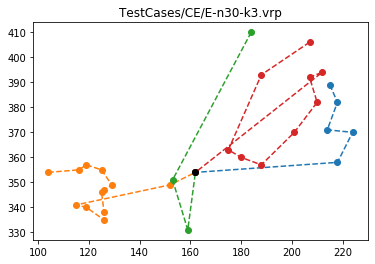

In [15]:
coordList = getCoordList2(filename2)
xlist = []
ylist = []
for route in B.tourList:
    x = []
    y = []
    for node in route:
        x.append(coordList[node][0])
        y.append(coordList[node][1])
    xlist.append(x)
    ylist.append(y)
RSSx = [coordList[0][0]]
RSSy = [coordList[0][1]]
for i in range(len(xlist)):
    plt.plot(xlist[i], ylist[i], marker='o', linestyle='--')
plt.plot(RSSx,RSSy, marker = 'o', linestyle = 'None', color = 'k')
plt.title(filename2)
plt.show()
time.sleep(3)

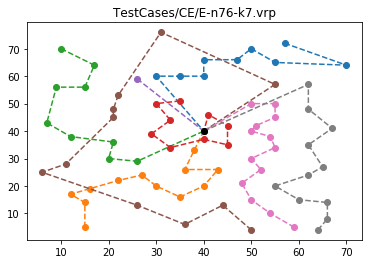

In [16]:
coordList = getCoordList2(filename1)
xlist = []
ylist = []
for route in G.tourList:
    x = []
    y = []
    for node in route:
        x.append(coordList[node][0])
        y.append(coordList[node][1])
    xlist.append(x)
    ylist.append(y)
RSSx = [coordList[0][0]]
RSSy = [coordList[0][1]]
for i in range(len(xlist)):
    plt.plot(xlist[i], ylist[i], marker='o', linestyle='--')
plt.plot(RSSx,RSSy, marker = 'o', linestyle = 'None', color = 'k')
plt.title(filename1)
plt.show()

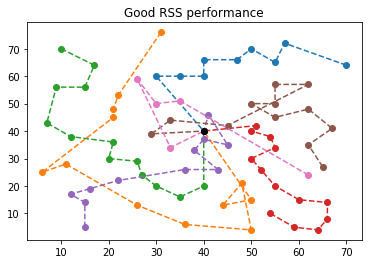

In [23]:
coordList = getCoordList2(filename2)
xlist = []
ylist = []
for route in B.tourList:
    x = []
    y = []
    for node in route:
        x.append(coordList[node][0])
        y.append(coordList[node][1])
    xlist.append(x)
    ylist.append(y)
RSSx = [coordList[0][0]]
RSSy = [coordList[0][1]]
for i in range(len(xlist)):
    plt.plot(xlist[i], ylist[i], marker='o', linestyle='--')
plt.plot(RSSx,RSSy, marker = 'o', linestyle = 'None', color = 'k')
plt.title('Good RSS performance')
plt.show()